# Calibration tests
### David Widmann

# Intro

In the following experiments we evaluate calibration test statistics of the model
```math
\begin{aligned}
   g(X) &\sim \mathrm{Dir}(\alpha),\\
   Z &\sim \mathrm{Ber}(\pi),\\
   Y \,|\, g(X) = \gamma, Z = 1 &\sim \mathrm{Cat}(\beta),\\
   Y \,|\, g(X) = \gamma, Z = 0 &\sim \mathrm{Cat}(\gamma),
\end{aligned}
```
where $\alpha \in \mathbb{R}_{>0}^m$ determines the distribution of predictions
$g(X)$, $\pi > 0$ determines the degree of miscalibration, and $\beta$ defines
a fixed categorical distribution. In our experiments we consider the two choices
$\alpha = (1,\ldots,1)$, corresponding to a uniform distribution of predictions,
and $\alpha = (0.1, \ldots, 0.1)$, mimicking a distribution after training that
is pushed towards the edges of the probability simplex. Moreover, we fix $\beta$
to $(1/m, \ldots, 1/m)$ and $(1, 0, \ldots, 0)$.

For the chosen parameters $\alpha = (a, \ldots, a)$ with $a = 1$ or $a = 0.1$
in our experiments, the analytic expected calibration error of the model is
```math
\mathbb{E}[\|.\|_{\mathrm{TV}},g] = \frac{\pi}{a B(a, (m-1) a)} {\left(\frac{{(m-1)}^{m-1}}{m^m}\right)}^a,
```
if $\beta = (1/m, \ldots, 1/m)$, and
```math
\mathbb{E}[\|.\|_{\mathrm{TV}},g] = \frac{\pi(m-1)}{m},
```
if $\beta = (1, 0, \ldots, 0)$. In general, the expected calibration error with
respect to the total variation distance is
```math
\mathbb{E}[\|.\|_{\mathrm{TV}},g] =
\pi \sum_{i=1}^m \left(\beta_i I(\beta_i; \alpha_i, \alpha_0 - \alpha_i)
- \frac{\alpha_i}{\alpha_0} I(\beta_i; \alpha_i + 1, \alpha_0 - \alpha_i)\right),
```
where $I(x; a, b) := B(x; a, b) / B(a, b)$ is the regularized incomplete Beta
function.

# Packages

We perform distributed computing to speed up our computations.

In [1]:
using Distributed

First we have to activate the local package environment on all cores.

In [2]:
@everywhere begin
    using Pkg
    Pkg.activate(joinpath(@__DIR__, ".."))
end

Activating environment at `~/Projects/julia/CalibrationPaper/experiments/Project.toml`


Then we load the packages that are required on all cores.

In [3]:
@everywhere begin
    using CalibrationPaper
    using CalibrationErrors
    using CalibrationTests
    using Distributions
    using Parameters
    using StatsBase

    using LinearAlgebra
    using Random
end

┌ Info: Precompiling CalibrationPaper [5e6d2ce1-a021-4f7d-b692-0c7af47336b0]
└ @ Base loading.jl:1273


We perform I/O and save the results as CSV files only on the main process.

In [4]:
using CSV
using DataFrames
using Plots
using ProgressMeter

using Statistics

theme(:wong2)
gr()

Plots.GRBackend()

# Experiments

## Setup

In our experiments we sample a data set of 250 labeled predictions from our generative
model. For this data set we approximate the p-value of a calibration test under the
null hypothesis that the model is calibrated. We repeat the sampling procedure multiple
times to obtain a distribution of the p-value approximations.

In [5]:
@everywhere struct Experiment{T,M<:CalibrationPaperModel}
    test::T
    model::M
end

@everywhere function Random.rand!(rng::AbstractRNG, experiment::Experiment, estimates,
                                  channel)
    @unpack test, model = experiment
    @unpack m, π, only_firstclass = model

    # define the distributions of predictions and labels
    prediction_gamma_sampler = sampler(Gamma(model.αᵢ))
    if !only_firstclass
        label_sampler = Random.Sampler(rng, 1:m)
    end

    # define the caches for predictions and labels
    predictions = [Vector{Float64}(undef, m) for _ in 1:250]
    labels = Vector{Int}(undef, 250)

    for i in 1:length(estimates)
        # sample the predictions
        for prediction in predictions
            rand!(rng, prediction_gamma_sampler, prediction)
            ldiv!(sum(prediction), prediction)
        end

        # sample the labels
        @inbounds for j in eachindex(labels)
            if π ≥ 1 || rand(rng) < π
                if only_firstclass
                    labels[j] = 1
                else
                    labels[j] = rand(rng, label_sampler)
                end
            else
                labels[j] = sample(rng, Weights(predictions[j], 1))
            end
        end

        # evaluate the estimator
        @inbounds estimates[i] = test(rng, predictions, labels)

        # update channel
        put!(channel, true)
    end

    estimates
end

We run these experiments 10000 times for $m \in \{2, 10\}$ classes,
$\alpha_i \in \{0.1, 1\}$, $\pi \in \{0, 0.5, 1\}$, and
$\beta = (1, 0, \ldots, 0)$ and $\beta = (1/m, \ldots, 1/m)$.
The results of each set of experiments is saved as a CSV file in the subdirectory
`data/pvalues`. To be able to reproduce our results we set the seed of the random number
generator to 1234 before each run.

In [6]:
function perform(test, experiment; n::Int = 10_000)
    # determine output file
    datadir = joinpath(@__DIR__, "..", "data", "pvalues")
    file = joinpath(datadir, "$experiment.csv")

    # do not overwrite existing files
    if isfile(file)
        @info "skipping experiment $experiment: $file exists"
        return
    end

    # create output directory if it does not exist
    isdir(datadir) || mkpath(datadir)

    # define the investigated models
    models = [CalibrationPaperModel(m, αᵢ, π, only_firstclass) for m in (2, 10),
              αᵢ in (0.1, 1.0), π in 0:0.5:1, only_firstclass in (true, false)]

    # define the pool of workers, the progress bar, and its update channel
    wp = CachingPool(workers())
    p = Progress(24 * n, 1, "running experiment $experiment...")
    channel = RemoteChannel(() -> Channel{Bool}(24 * n))

    local estimates
    @sync begin
        # update the progress bar
        @async while take!(channel)
            next!(p)
        end

        # compute the p-value approximations for all models
        estimates = let rng = Random.GLOBAL_RNG, test = test, n = n, channel = channel
            pmap(wp, models) do model
                # copy random number generator and set seed
                _rng = deepcopy(rng)
                Random.seed!(_rng, 1234)

                # perform experiment
                rand!(_rng, Experiment(test(model), model), Vector{Float64}(undef, n),
                      channel)
            end
        end

        # stop progress bar
        put!(channel, false)
    end

    # save estimates
    @info "saving experiment $experiment..."
    open(file, "w") do f
        @inbounds for i in 1:length(models)
            # obtain model
            model = models[i]

            # create data frame
            df = DataFrame(estimate = estimates[i],  m = model.m, αᵢ = model.αᵢ, π = model.π,
                           only_firstclass = model.only_firstclass)
            # save it
            CSV.write(f, df; append = i > 1)
        end
    end

    nothing
end

perform (generic function with 1 method)

## Plotting results

We plot the empirical type I and type II errors that we
observe in our experiments, depending on the significance level that we impose. More
concretely, for a fixed set of significance levels $\alpha \in \{0, 1e-3, 2e-3, \ldots,
0.999, 1\}$, we compute the empirical approximations
```math
\mathbb{P}[P \leq \alpha] \approx \frac{1}{N} \|\{ i \colon p_i < \alpha \}\| =: f(\alpha),
```
where $P$ is the studied p-value approximation (which is a data dependent random
variable) and $p_1, \ldots, p_N$ are the empirically observed realizations of this
estimator. For calibrated models, $\mathbb{P}[P \leq \alpha] \approx f(\alpha)$ is the probability of
false rejection (type I error) of a statistical test with significance level $\alpha$
and p-value approximation $P$, whereas for uncalibrated models
$\mathbb{P}[P > \alpha] \approx 1 - f(\alpha)$ is the probability of false non-rejection
(type II error) of a statistical test with significance level $\alpha$ and p-value
approximation $P$. Thus for calibrated models we plot $f(\alpha)$ versus $\alpha$,
and for uncalibrated models $1 - f(\alpha)$ versus
$\alpha$. Actually, by definition the type I error of a statistical test of significance
level $\alpha$ has to be smaller or equal than $\alpha$. To be able to check this
property visually, we plot the diagonal of the unit square as well.

In [7]:
@userplot ErrorGrid

@recipe function f(h::ErrorGrid)
    # extract experiment
    experiment = h.args[1]

    # extract parameter setting of distributions of predictions and labels
    αᵢ = pop!(plotattributes, :αᵢ)
    only_firstclass = pop!(plotattributes, :only_firstclass)

    # default settings
    layout := (2, 3)
    size --> (864, 480)
    linewidth --> 2
    legend --> false
    xlabel --> "p-value approximation"
    ylabel --> "empirical test error"
    seriestype --> :path

    # define studied models
    models = [CalibrationPaperModel(m, αᵢ, π, only_firstclass) for π in 0:0.5:1, m in (2, 10)]

    # load estimates of p-value approximations
    file = joinpath(@__DIR__, "..", "data", "pvalues", "$experiment.csv")
    df = CSV.read(file)

    αs = 0:0.01:1
    for (i, model) in enumerate(models)
        # select estimates of p-value approximations
        estimates = collect_estimates(df, model)

        # estimate the empirical CDF
        empiricalCDF = ecdf(estimates)

        # add next subplot
        subplot := i
        title := "m = $(model.m), pi = $(model.π)"

        if iszero(model.π)
            # if the model is calibrated we plot the empirical type I error
            @series begin
                αs, empiricalCDF.(αs)
            end

            # plot the diagonal
            @series begin
                linestyle := :dash
                [0, 1], [0, 1]
            end
        else
            # otherwise we plot the empirical type II error
            @series begin
                αs, 1 .- empiricalCDF.(αs)
            end
        end
    end
end

## Consistency resampling test based on the expected calibration error

We start by analyzing the consistency resampling test based on the expected
calibration error (ECE). In this test, we perform consistency resampling, i.e.,
resampling of consistent labels from resampled prediction data sets, and
evaluate the ECE. We approximate the p-value by the empirical ratio of bootstrap
samples that were greater or equal than the ECE of the original data set.

### Uniform binning

For our estimation we use 10 bins of uniform width in each dimension.

In [8]:
perform("ECE_uniform") do model
    (rng, predictions, labels) -> pvalue(ConsistencyTest(ECE(UniformBinning(10)), predictions, labels); rng = rng)
end

┌ Info: skipping experiment ECE_uniform: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/ECE_uniform.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

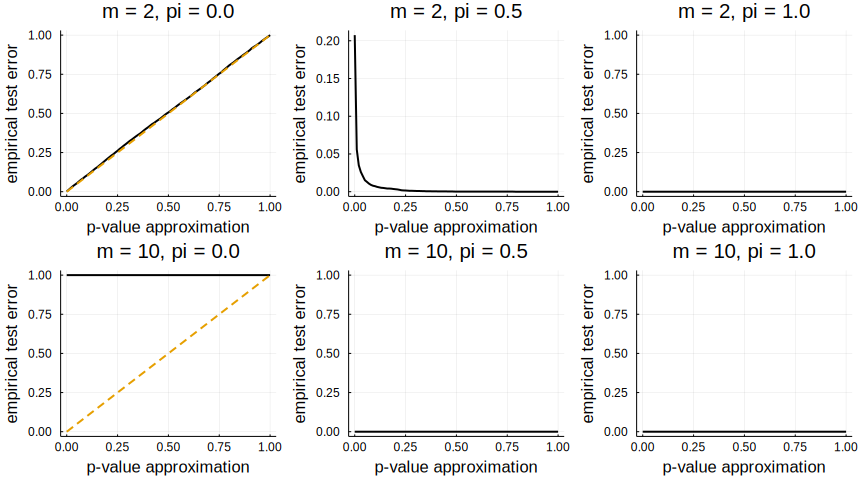

In [9]:
errorgrid("ECE_uniform"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

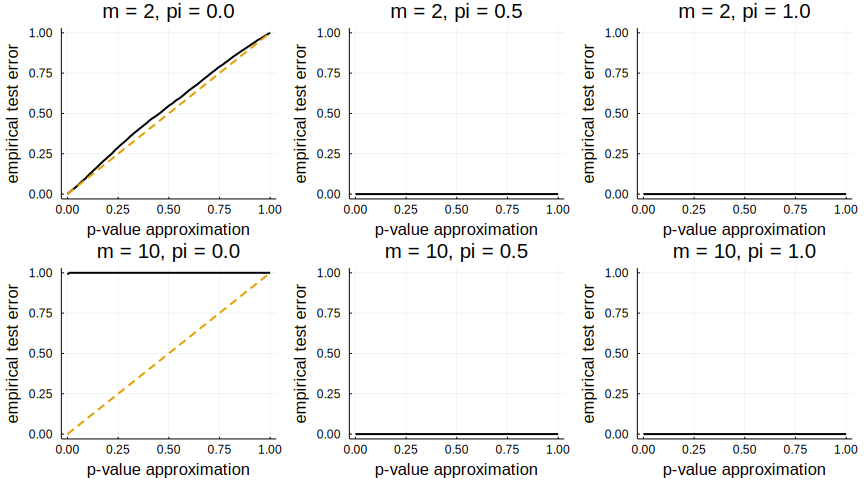

In [10]:
errorgrid("ECE_uniform"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

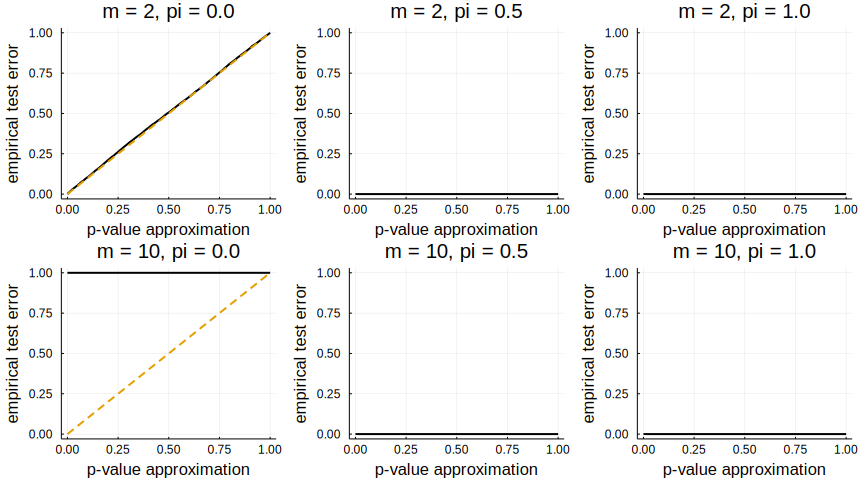

In [11]:
errorgrid("ECE_uniform"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

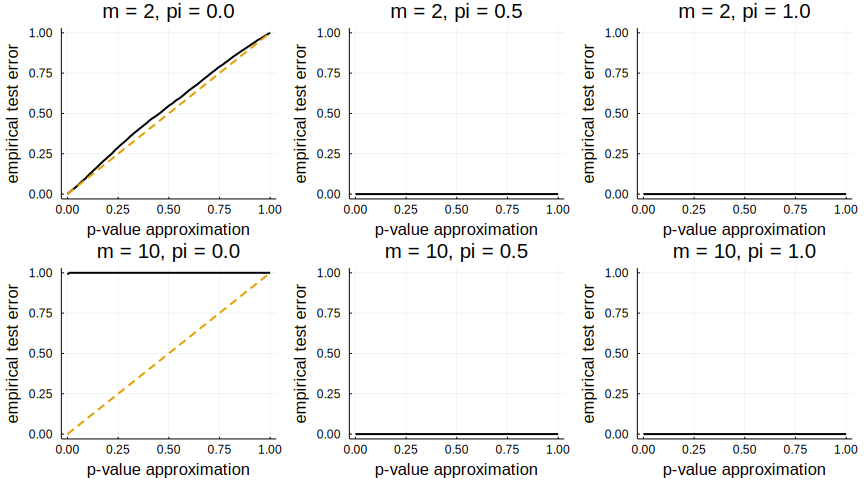

In [12]:
errorgrid("ECE_uniform"; αᵢ = 0.1, only_firstclass = true)

### Non-uniform binning

In [13]:
perform("ECE_dynamic") do model
    (rng, predictions, labels) -> pvalue(ConsistencyTest(ECE(MedianVarianceBinning(5)), predictions, labels); rng = rng)
end

┌ Info: skipping experiment ECE_dynamic: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/ECE_dynamic.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

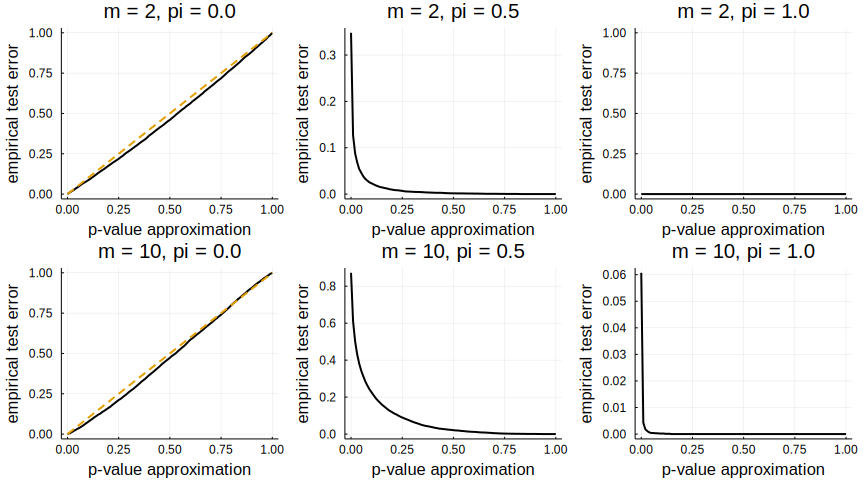

In [14]:
errorgrid("ECE_dynamic"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

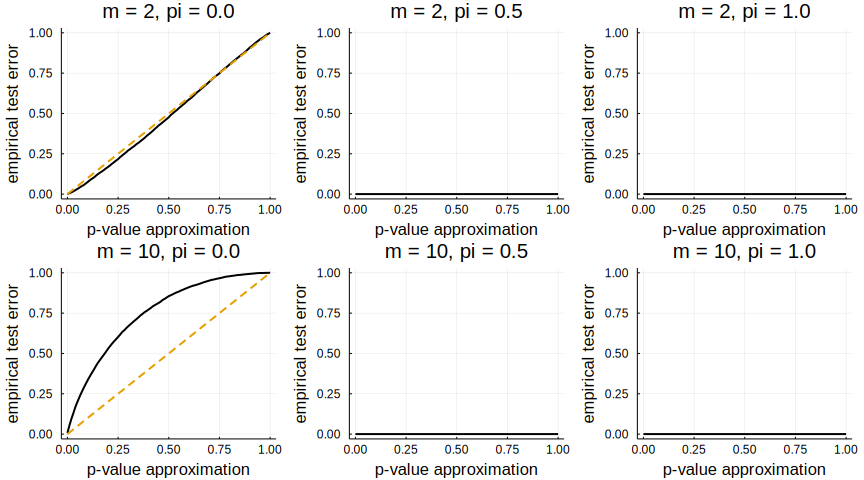

In [15]:
errorgrid("ECE_dynamic"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

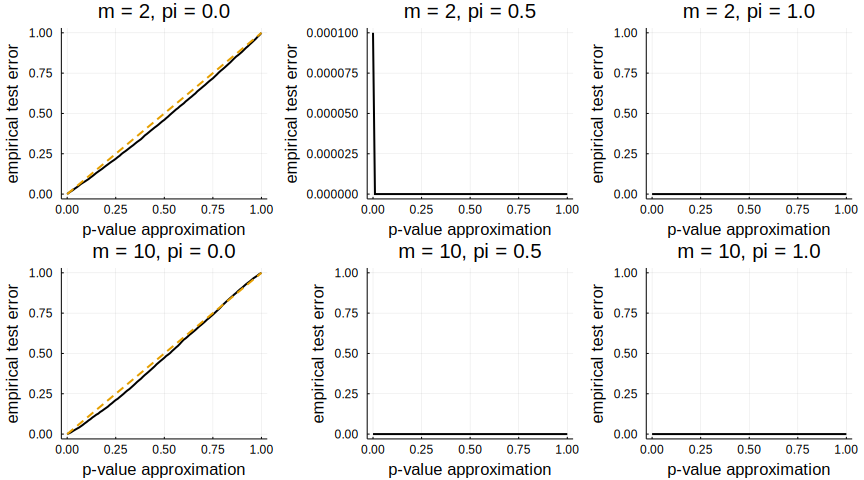

In [16]:
errorgrid("ECE_dynamic"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

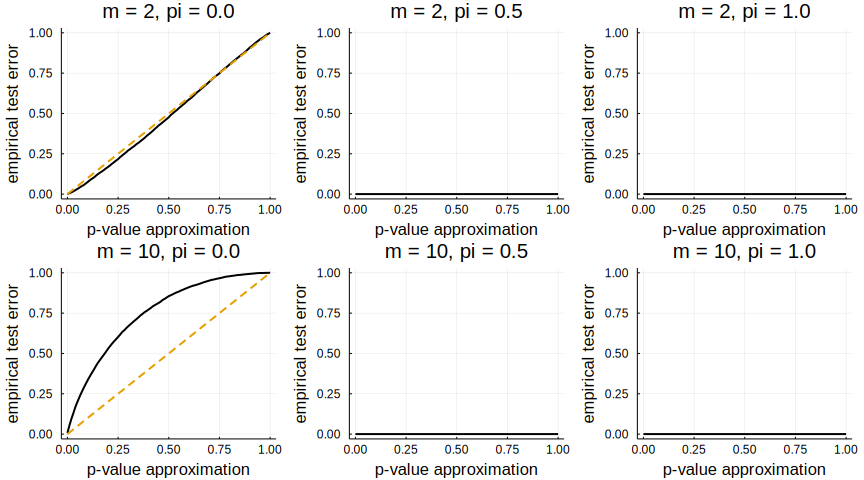

In [17]:
errorgrid("ECE_dynamic"; αᵢ = 0.1, only_firstclass = true)

## Distribution-free test for the biased estimator of the squared kernel calibration error

### Median heuristic

First we try the median heuristic.

In [18]:
perform("SKCEb_median_distribution_free") do model
    (rng, predictions, labels) -> pvalue(DistributionFreeTest(BiasedSKCE(median_TV_kernel(predictions)), predictions, labels))
end

┌ Info: skipping experiment SKCEb_median_distribution_free: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/SKCEb_median_distribution_free.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

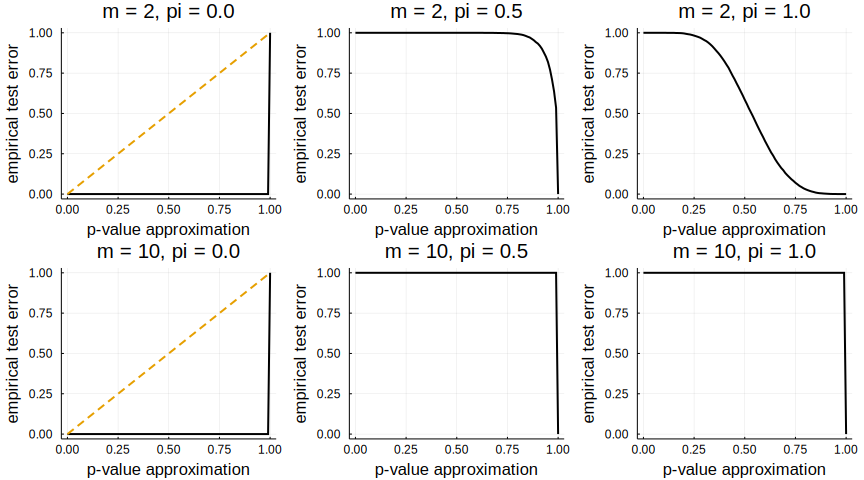

In [19]:
errorgrid("SKCEb_median_distribution_free"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

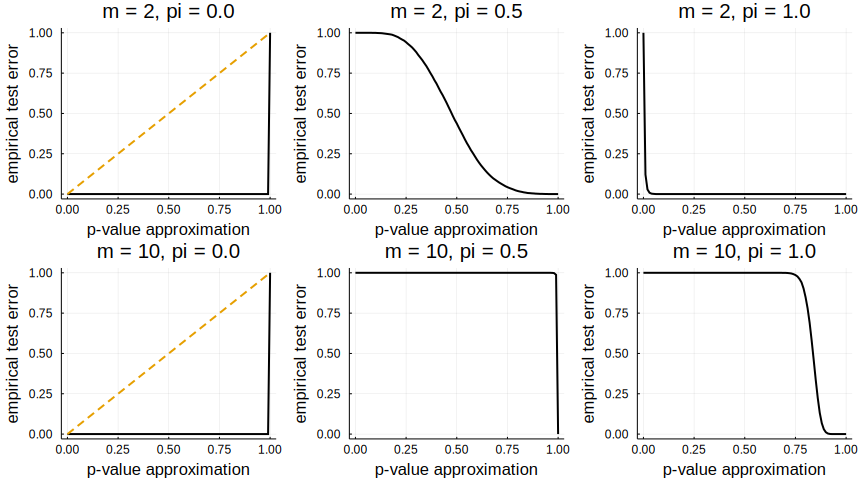

In [20]:
errorgrid("SKCEb_median_distribution_free"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

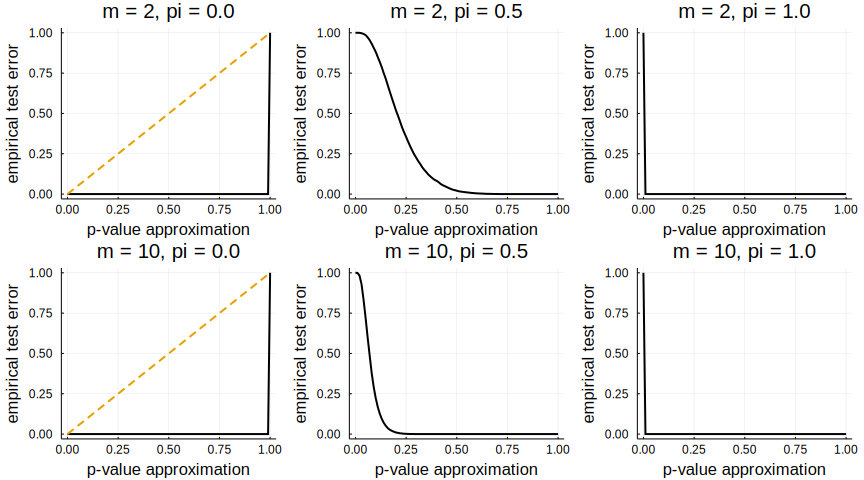

In [21]:
errorgrid("SKCEb_median_distribution_free"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

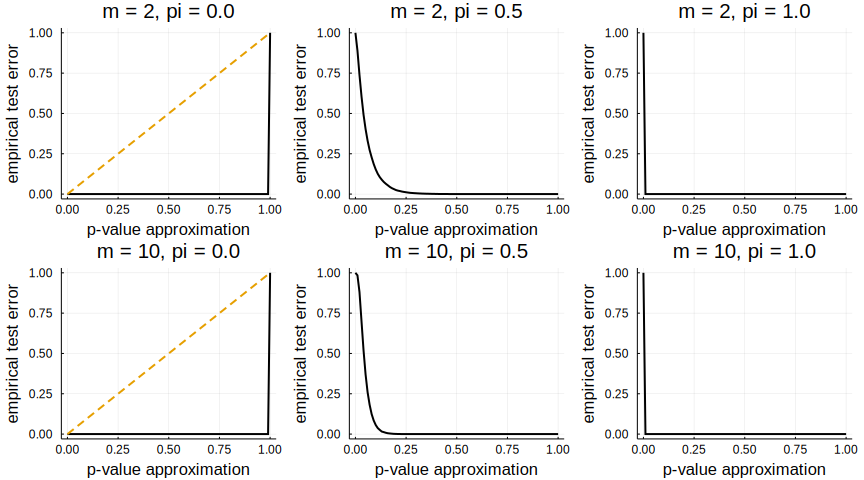

In [22]:
errorgrid("SKCEb_median_distribution_free"; αᵢ = 0.1, only_firstclass = true)

### Mean distance

We repeat the simulations with the mean total variation distance as bandwidth.

In [23]:
perform("SKCEb_mean_distribution_free") do model
    let kernel = mean_TV_kernel(model)
        (rng, predictions, labels) -> pvalue(DistributionFreeTest(BiasedSKCE(kernel), predictions, labels))
    end
end

┌ Info: skipping experiment SKCEb_mean_distribution_free: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/SKCEb_mean_distribution_free.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

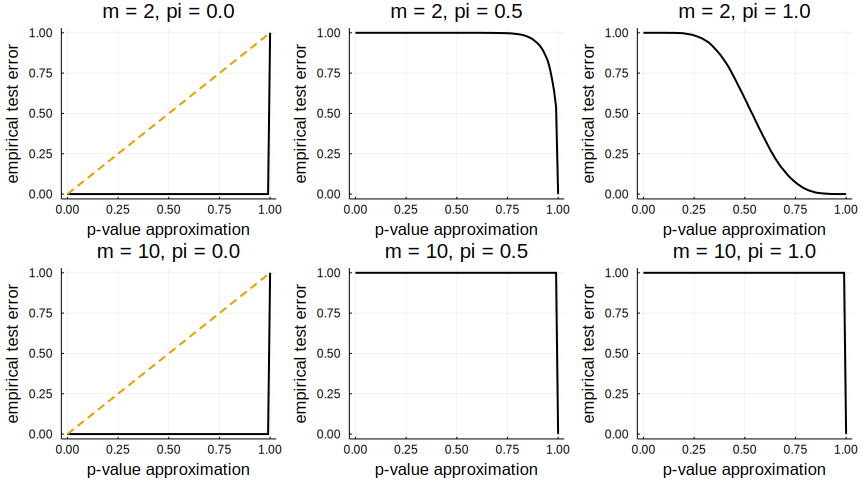

In [24]:
errorgrid("SKCEb_mean_distribution_free"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

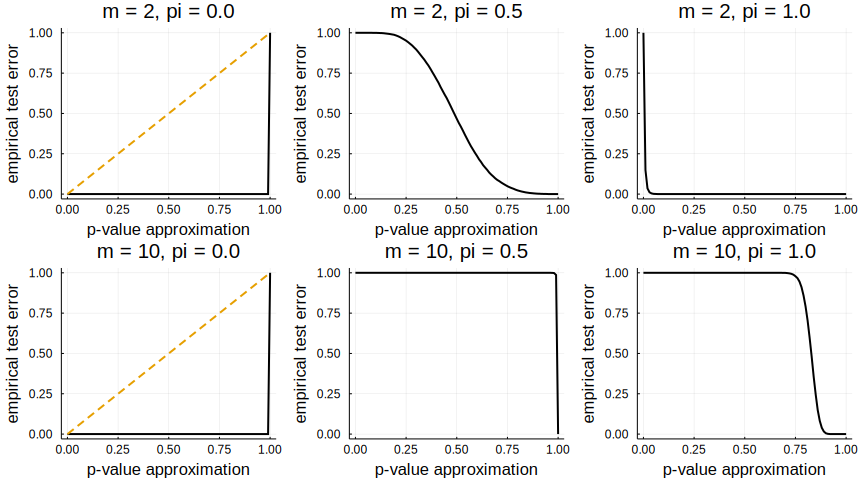

In [25]:
errorgrid("SKCEb_mean_distribution_free"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

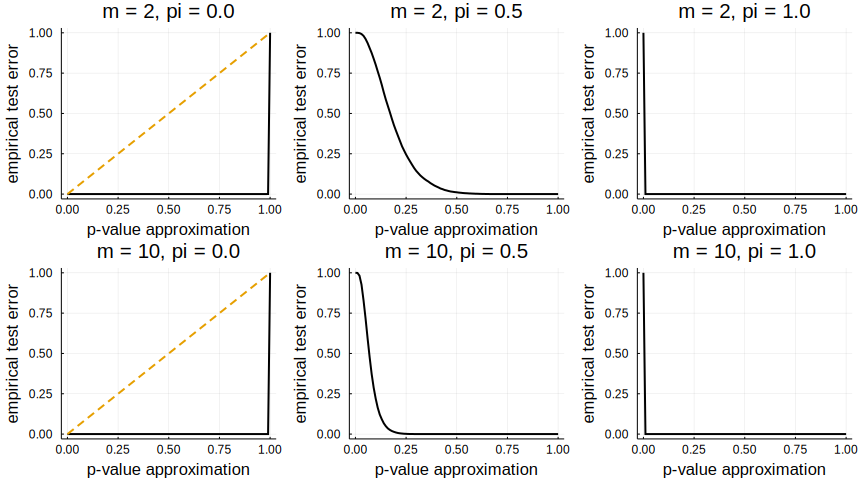

In [26]:
errorgrid("SKCEb_mean_distribution_free"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

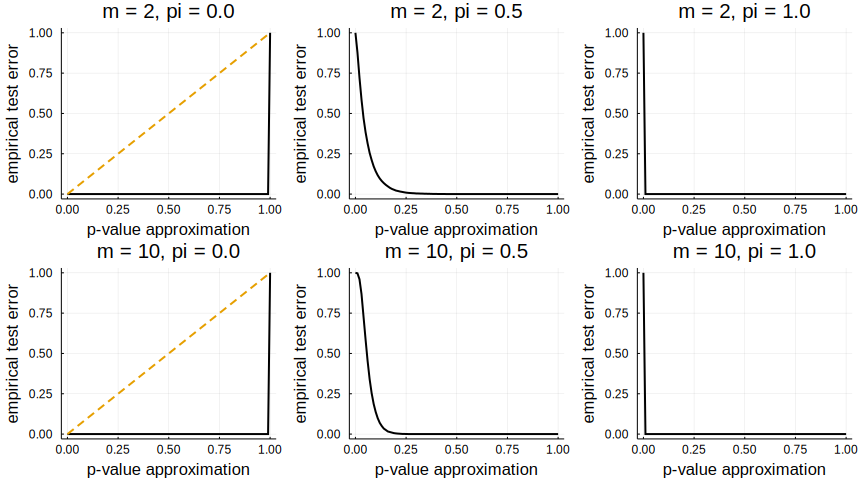

In [27]:
errorgrid("SKCEb_mean_distribution_free"; αᵢ = 0.1, only_firstclass = true)

## Distribution-free test for the unbiased quadratic estimator of the squared kernel calibration error

### Median heuristic

First we try the median heuristic.

In [28]:
perform("SKCEuq_median_distribution_free") do model
    (rng, predictions, labels) -> pvalue(DistributionFreeTest(QuadraticUnbiasedSKCE(median_TV_kernel(predictions)), predictions, labels))
end

┌ Info: skipping experiment SKCEuq_median_distribution_free: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/SKCEuq_median_distribution_free.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

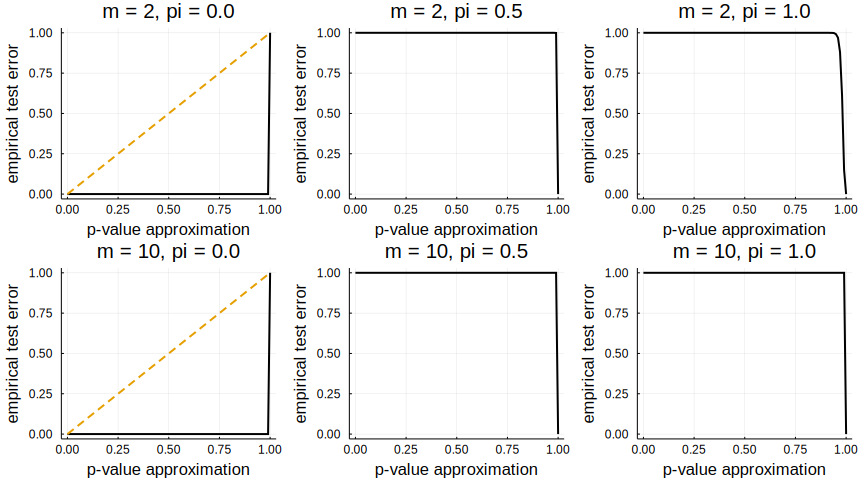

In [29]:
errorgrid("SKCEuq_median_distribution_free"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

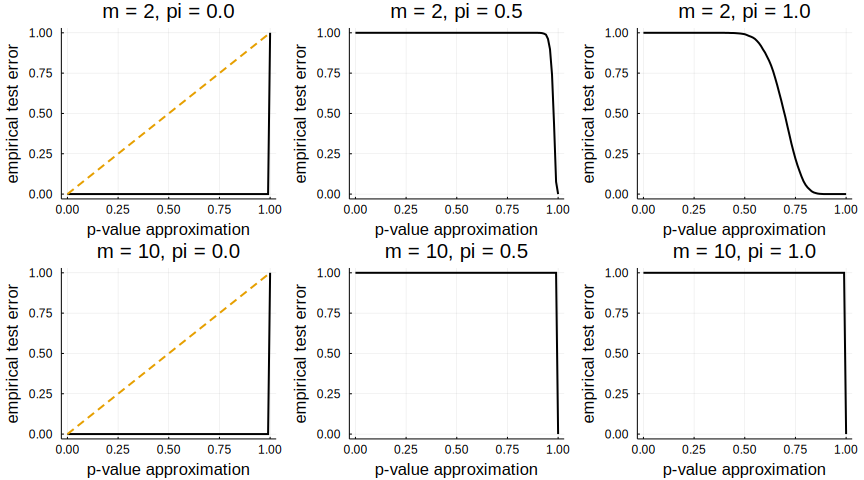

In [30]:
errorgrid("SKCEuq_median_distribution_free"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

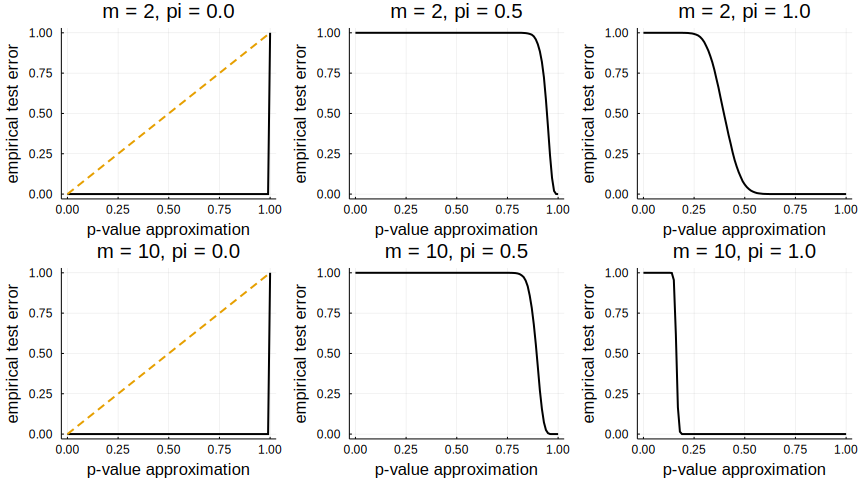

In [31]:
errorgrid("SKCEuq_median_distribution_free"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

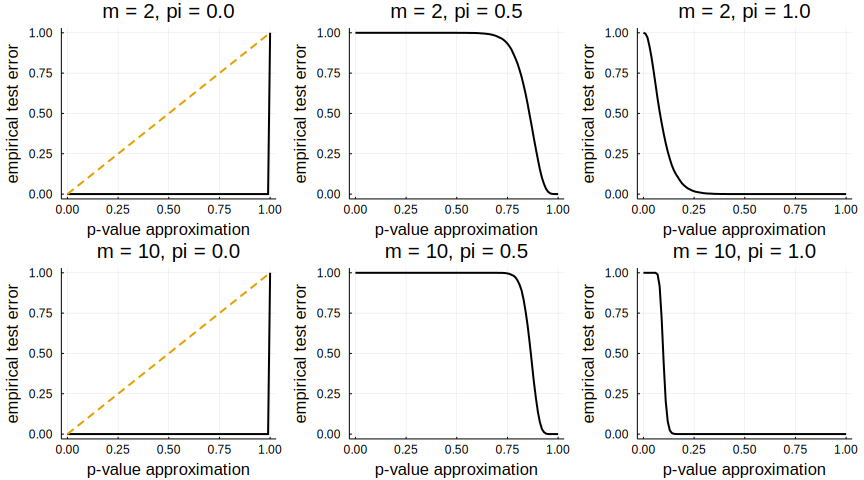

In [32]:
errorgrid("SKCEuq_median_distribution_free"; αᵢ = 0.1, only_firstclass = true)

### Mean distance

We repeat the simulations with the mean total variation distance as bandwidth.

In [33]:
perform("SKCEuq_mean_distribution_free") do model
    let kernel = mean_TV_kernel(model)
        (rng, predictions, labels) -> pvalue(DistributionFreeTest(QuadraticUnbiasedSKCE(kernel), predictions, labels))
    end
end

┌ Info: skipping experiment SKCEuq_mean_distribution_free: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/SKCEuq_mean_distribution_free.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

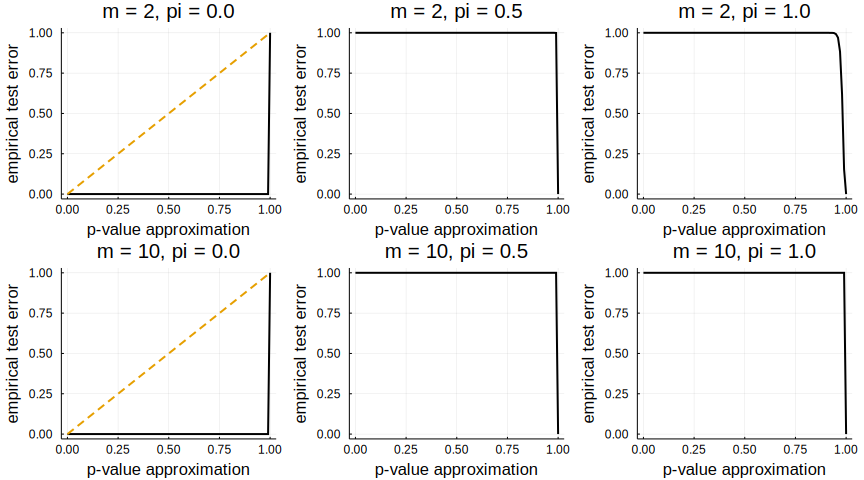

In [34]:
errorgrid("SKCEuq_mean_distribution_free"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

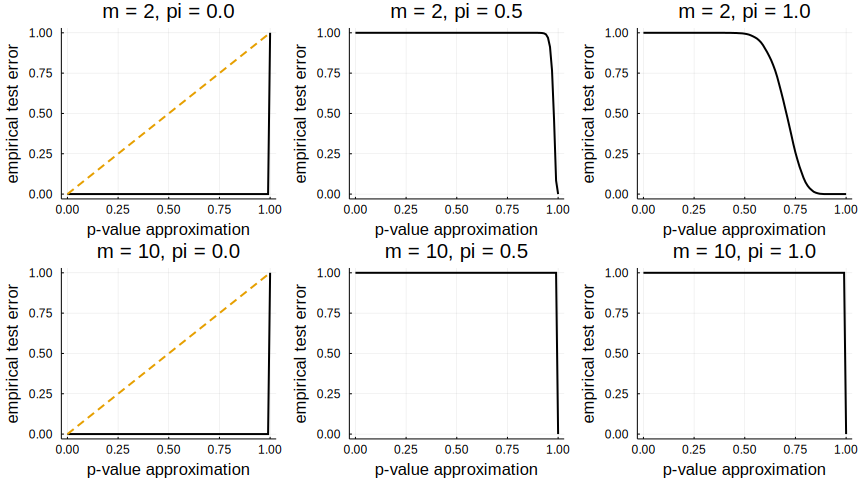

In [35]:
errorgrid("SKCEuq_mean_distribution_free"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

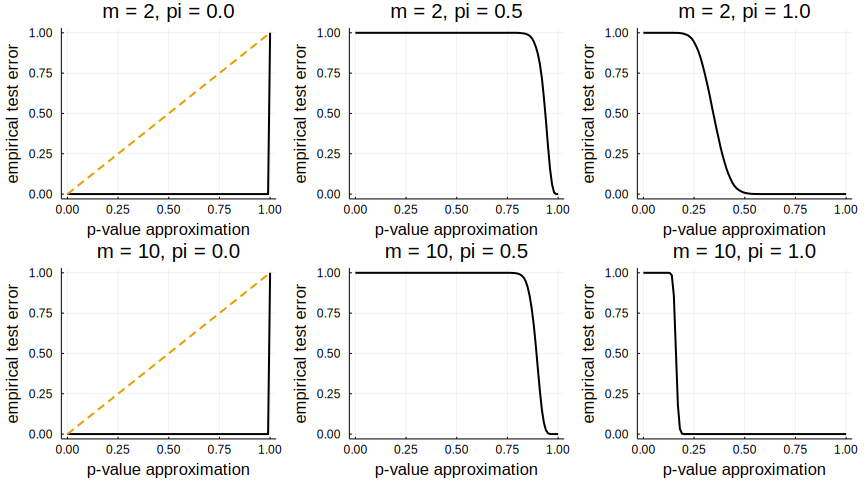

In [36]:
errorgrid("SKCEuq_mean_distribution_free"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

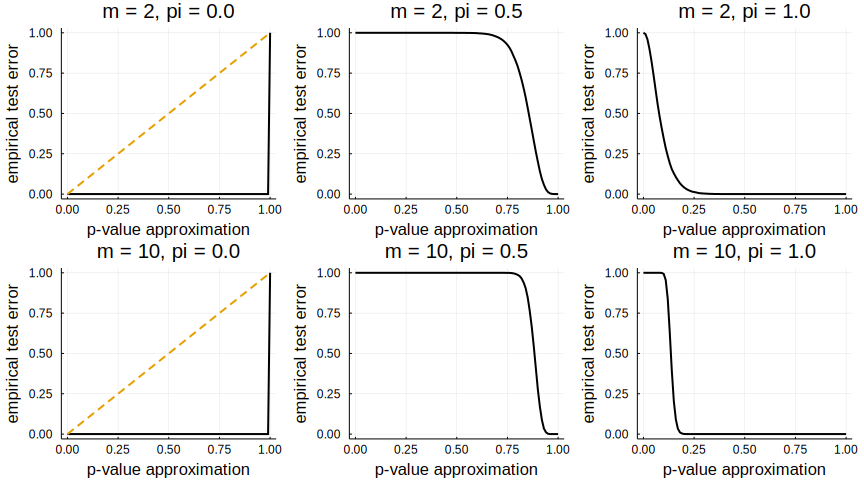

In [37]:
errorgrid("SKCEuq_mean_distribution_free"; αᵢ = 0.1, only_firstclass = true)

## Distribution-free test for the unbiased linear estimator of the squared kernel calibration error

### Median heuristic

First we try the median heuristic.

In [38]:
perform("SKCEul_median_distribution_free") do model
    (rng, predictions, labels) -> pvalue(DistributionFreeTest(LinearUnbiasedSKCE(median_TV_kernel(predictions)), predictions, labels))
end

┌ Info: skipping experiment SKCEul_median_distribution_free: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/SKCEul_median_distribution_free.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

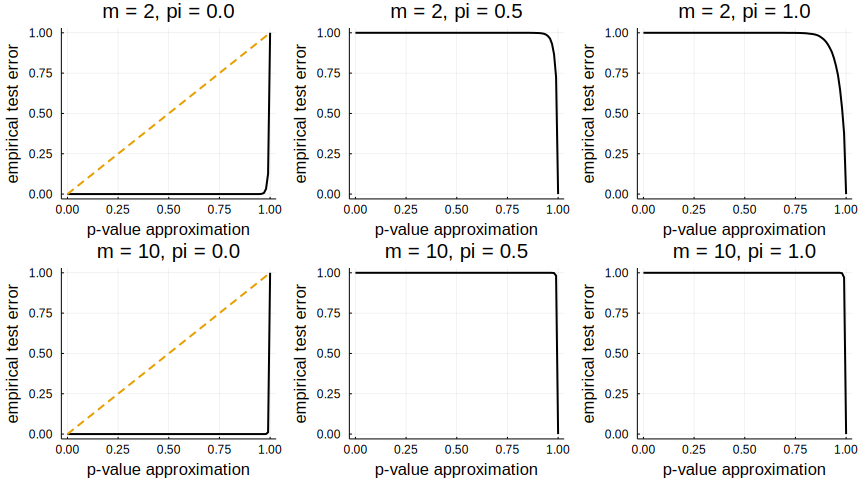

In [39]:
errorgrid("SKCEul_median_distribution_free"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

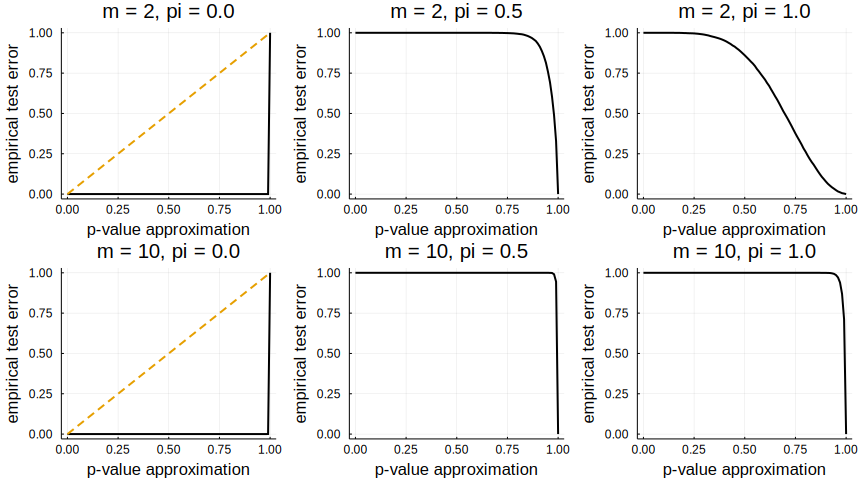

In [40]:
errorgrid("SKCEul_median_distribution_free"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

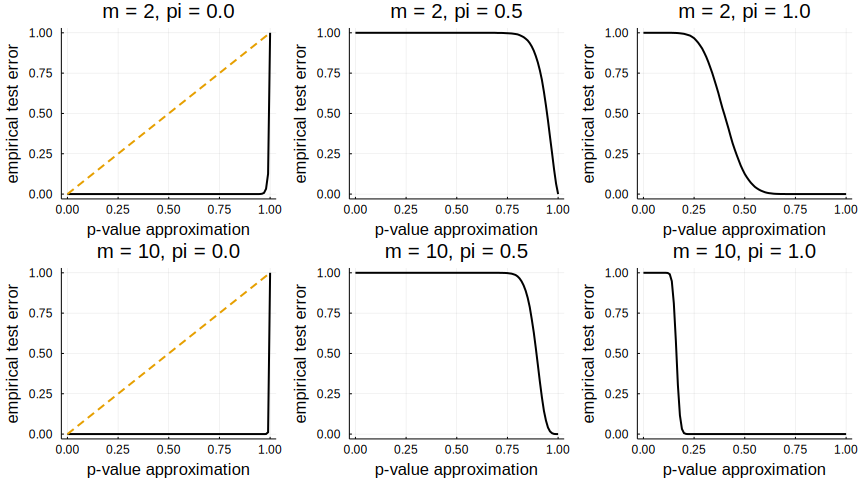

In [41]:
errorgrid("SKCEul_median_distribution_free"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

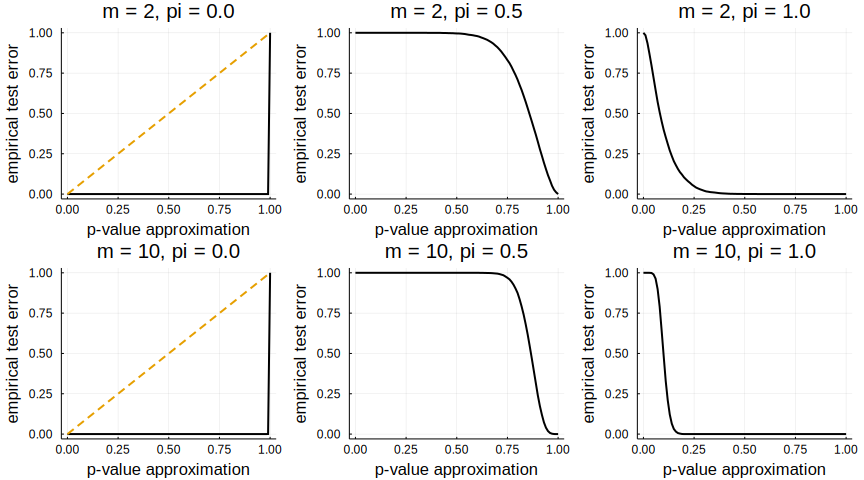

In [42]:
errorgrid("SKCEul_median_distribution_free"; αᵢ = 0.1, only_firstclass = true)

### Mean distance

We repeat the simulations with the mean total variation distance as bandwidth.

In [43]:
perform("SKCEul_mean_distribution_free") do model
    let kernel = mean_TV_kernel(model)
        (rng, predictions, labels) -> pvalue(DistributionFreeTest(LinearUnbiasedSKCE(kernel), predictions, labels))
    end
end

┌ Info: skipping experiment SKCEul_mean_distribution_free: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/SKCEul_mean_distribution_free.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

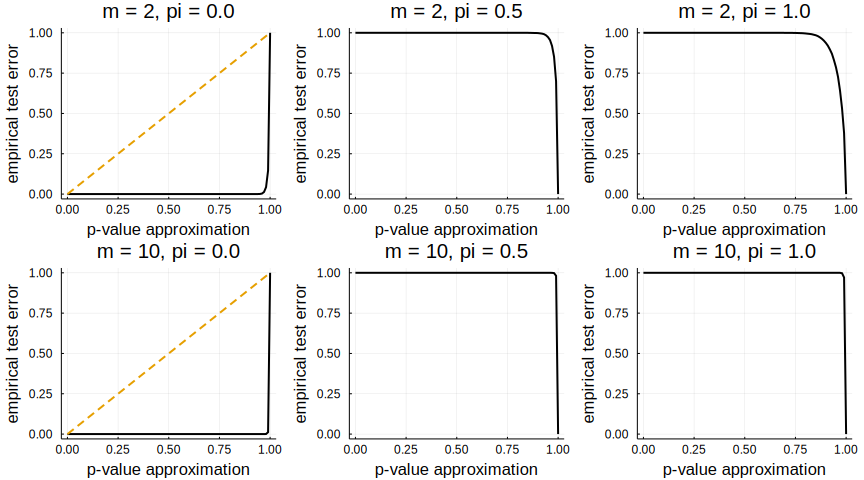

In [44]:
errorgrid("SKCEul_mean_distribution_free"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

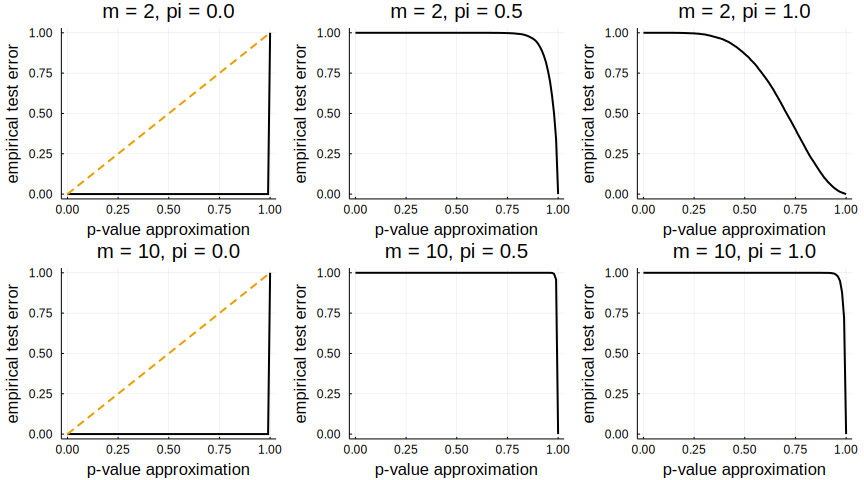

In [45]:
errorgrid("SKCEul_mean_distribution_free"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

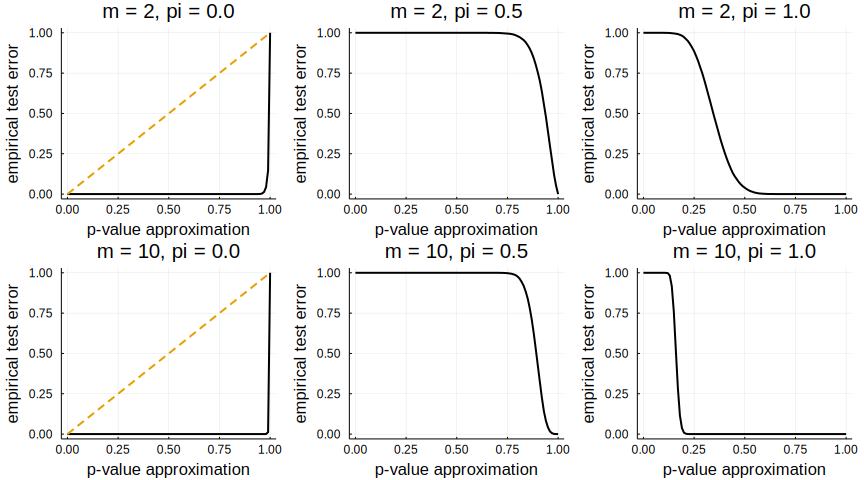

In [46]:
errorgrid("SKCEul_mean_distribution_free"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

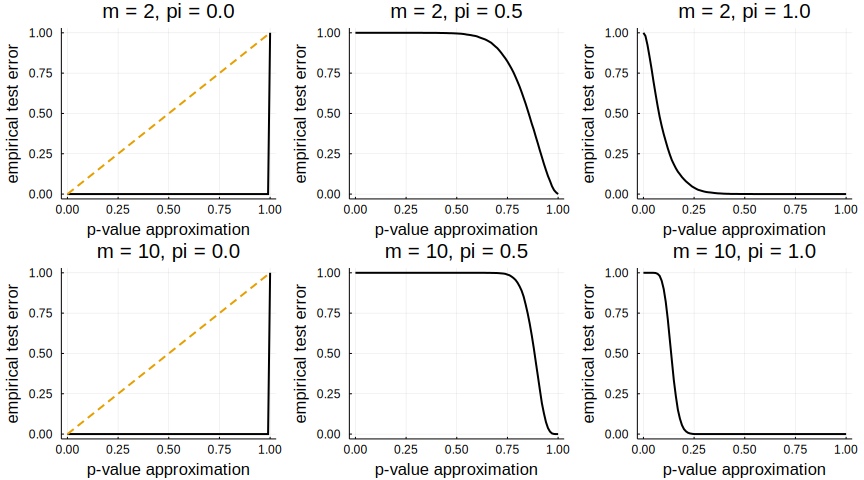

In [47]:
errorgrid("SKCEul_mean_distribution_free"; αᵢ = 0.1, only_firstclass = true)

## Asymptotic test for the unbiased linear estimator of the squared kernel calibration error

### Median heuristic

First we try the median heuristic.

In [48]:
perform("SKCEul_median_asymptotic") do model
    (rng, predictions, labels) -> pvalue(AsymptoticLinearTest(median_TV_kernel(predictions), predictions, labels))
end

┌ Info: skipping experiment SKCEul_median_asymptotic: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/SKCEul_median_asymptotic.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

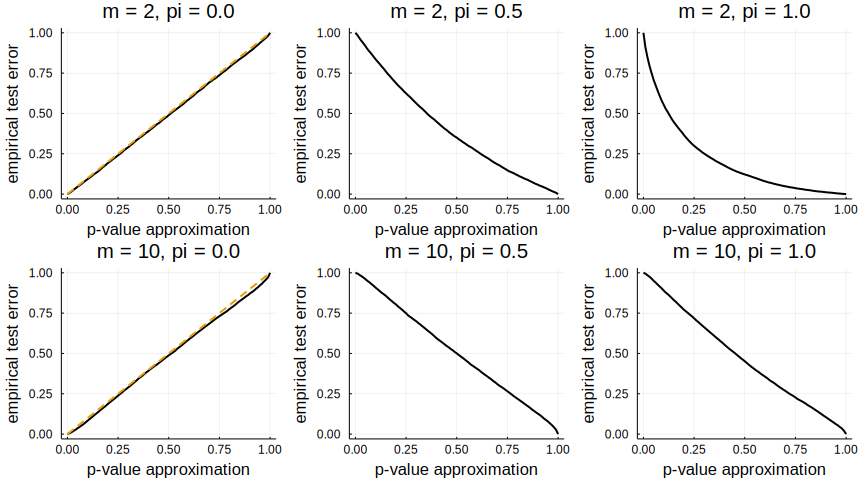

In [49]:
errorgrid("SKCEul_median_asymptotic"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

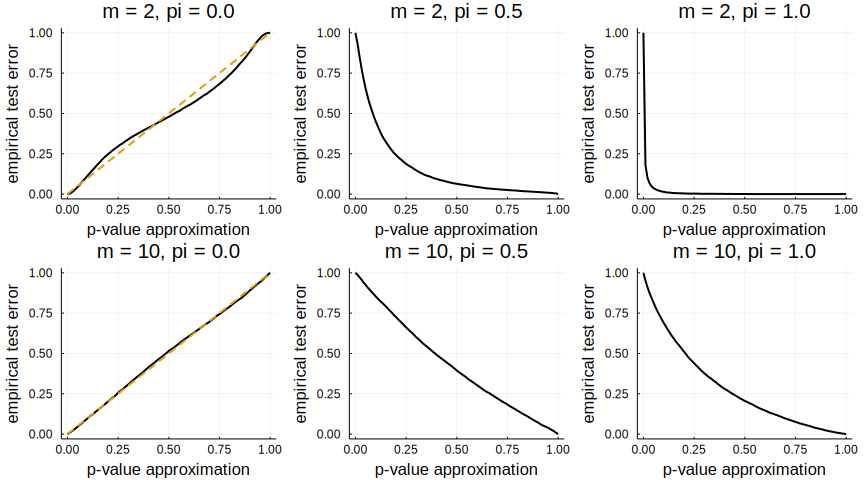

In [50]:
errorgrid("SKCEul_median_asymptotic"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

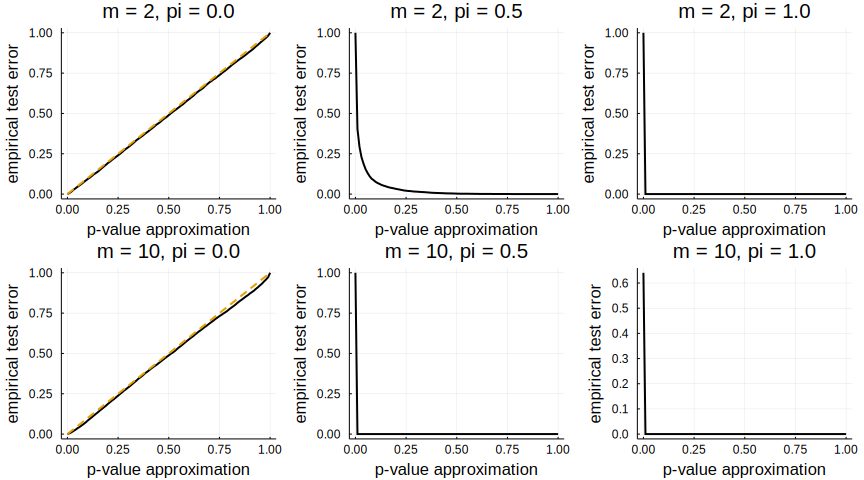

In [51]:
errorgrid("SKCEul_median_asymptotic"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

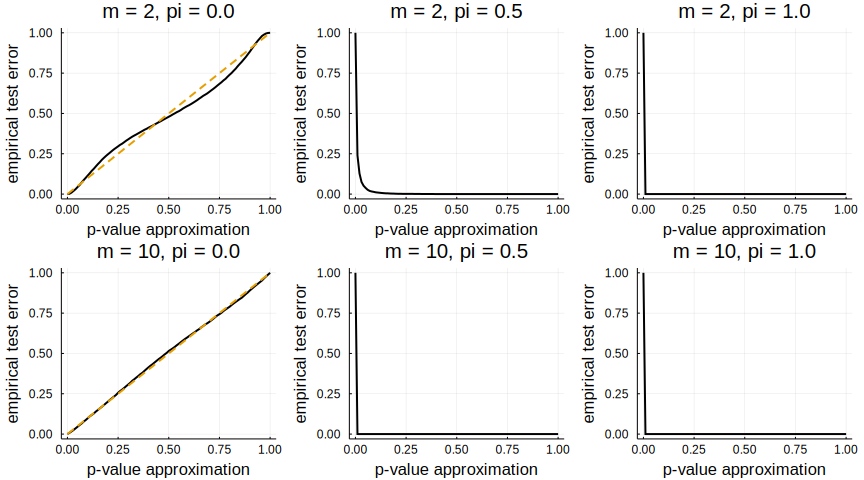

In [52]:
errorgrid("SKCEul_median_asymptotic"; αᵢ = 0.1, only_firstclass = true)

### Mean distance

We repeat the simulations with the mean total variation distance as bandwidth.

In [53]:
perform("SKCEul_mean_asymptotic") do model
    let kernel = mean_TV_kernel(model)
        (rng, predictions, labels) -> pvalue(AsymptoticLinearTest(kernel, predictions, labels))
    end
end

┌ Info: skipping experiment SKCEul_mean_asymptotic: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/SKCEul_mean_asymptotic.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

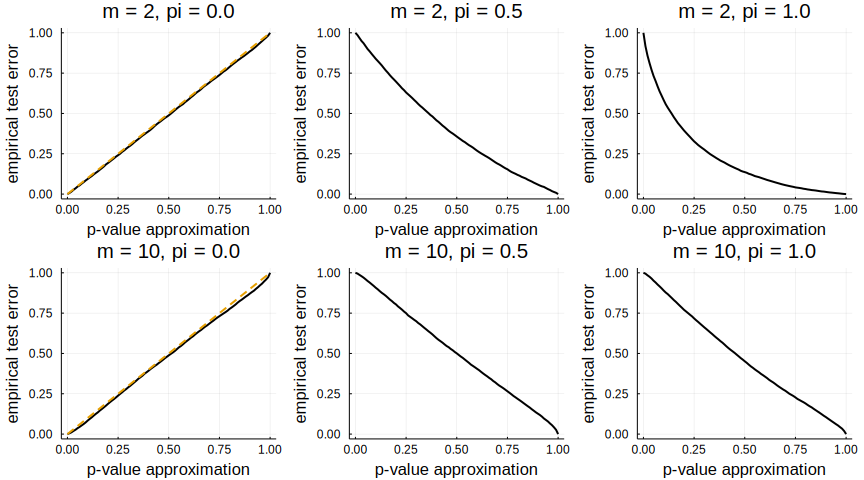

In [54]:
errorgrid("SKCEul_mean_asymptotic"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

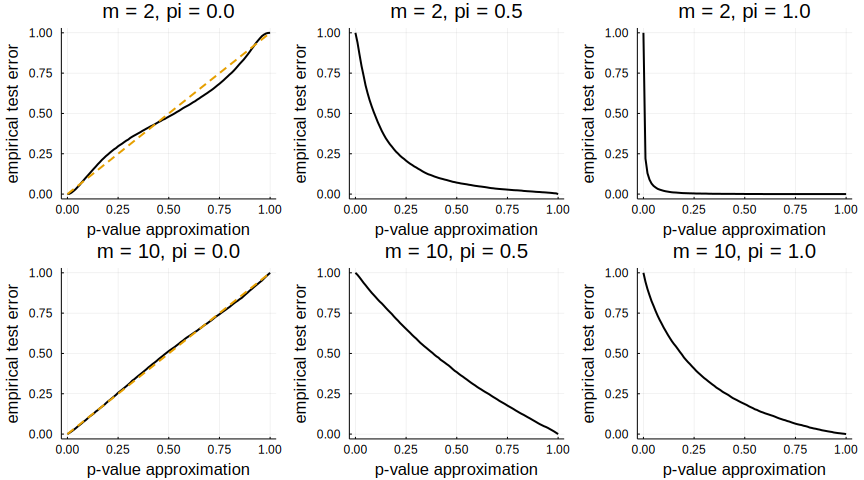

In [55]:
errorgrid("SKCEul_mean_asymptotic"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

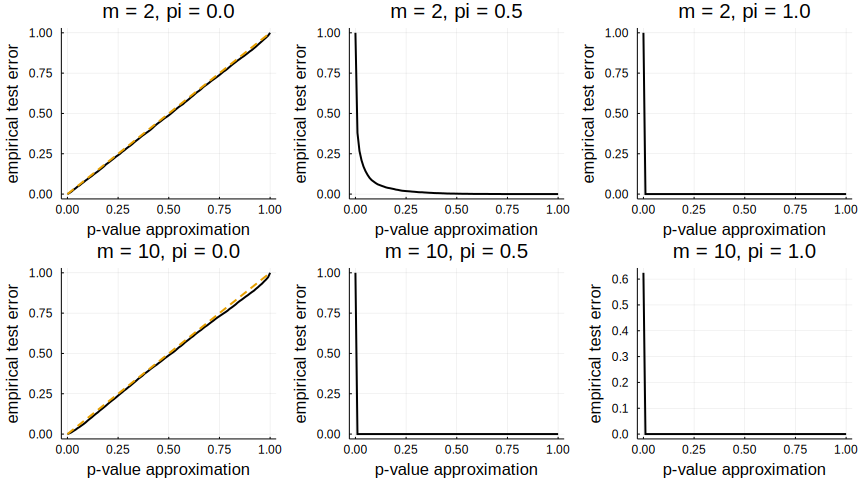

In [56]:
errorgrid("SKCEul_mean_asymptotic"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

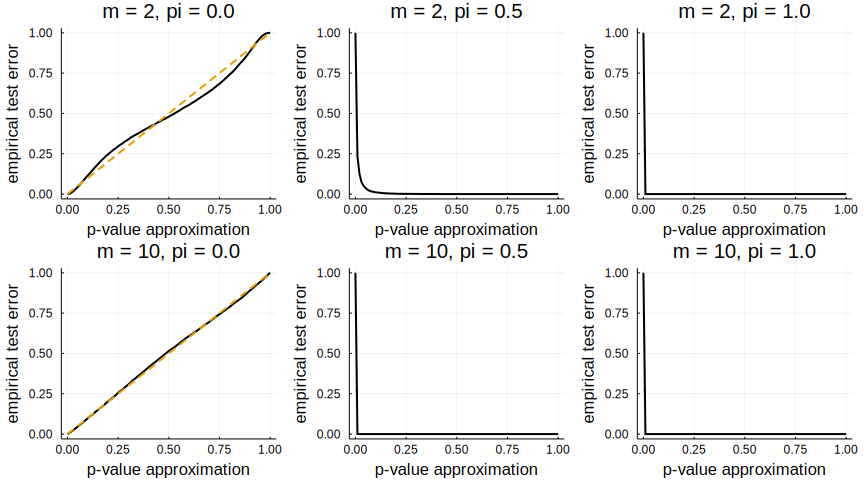

In [57]:
errorgrid("SKCEul_mean_asymptotic"; αᵢ = 0.1, only_firstclass = true)

## Asymptotic test for the unbiased quadratic estimator of the squared kernel calibration error

### Median heuristic

First we try the median heuristic.

In [58]:
perform("SKCEuq_median_asymptotic") do model
    (rng, predictions, labels) -> pvalue(AsymptoticQuadraticTest(median_TV_kernel(predictions), predictions, labels); rng = rng)
end

┌ Info: skipping experiment SKCEuq_median_asymptotic: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/SKCEuq_median_asymptotic.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

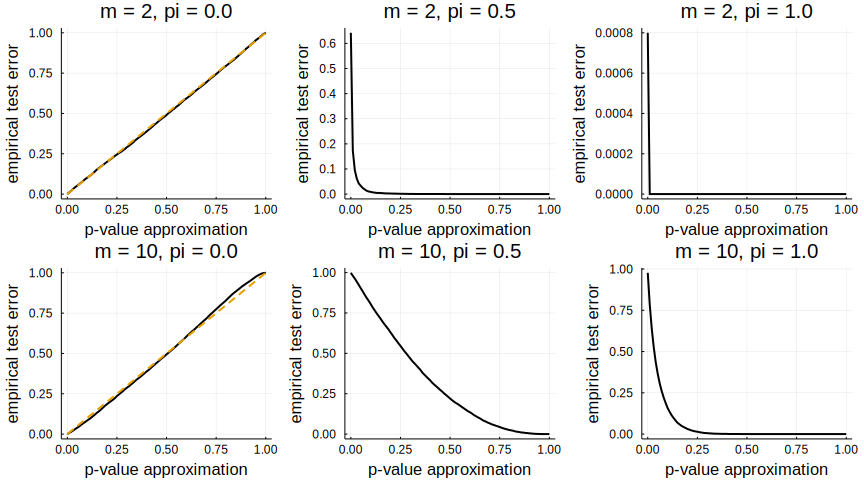

In [59]:
errorgrid("SKCEuq_median_asymptotic"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

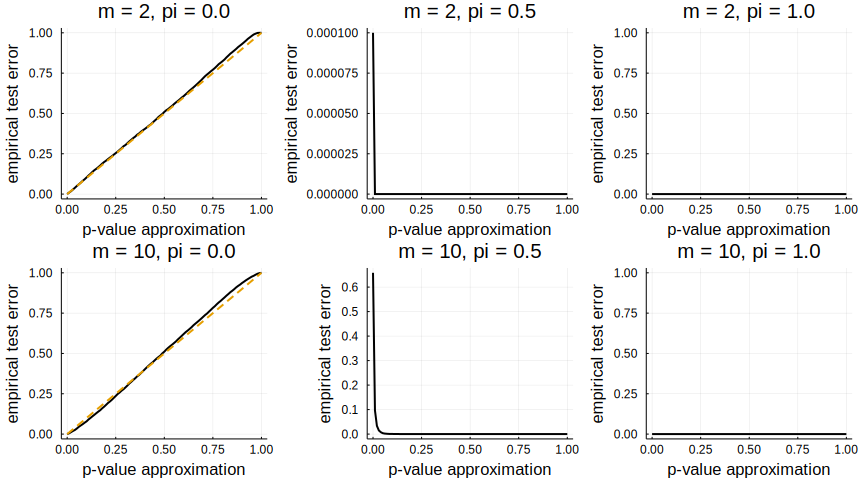

In [60]:
errorgrid("SKCEuq_median_asymptotic"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

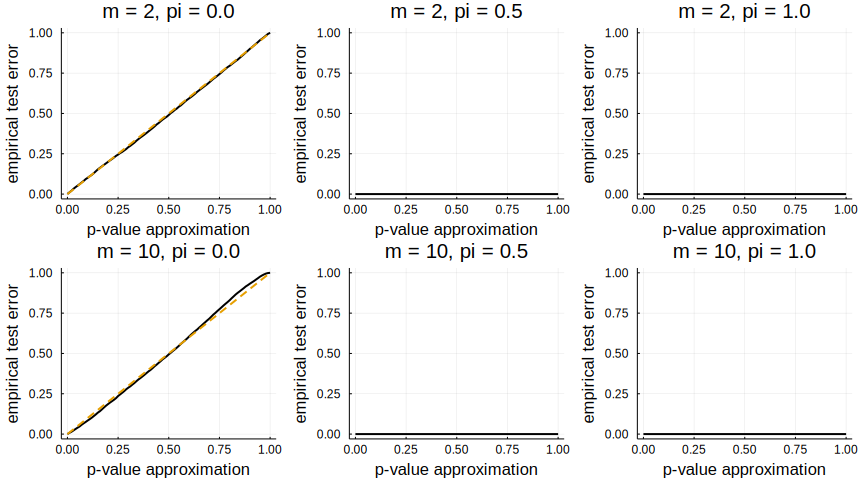

In [61]:
errorgrid("SKCEuq_median_asymptotic"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

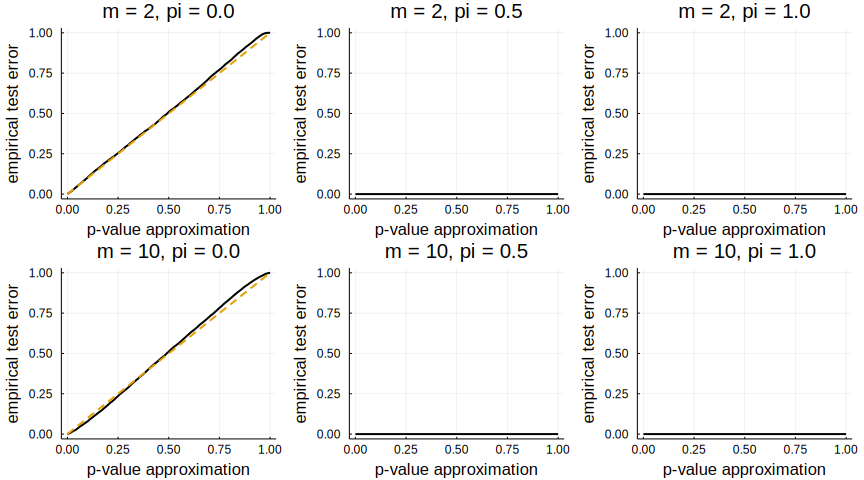

In [62]:
errorgrid("SKCEuq_median_asymptotic"; αᵢ = 0.1, only_firstclass = true)

### Mean distance

We repeat the simulations with the mean total variation distance as bandwidth.

In [63]:
perform("SKCEuq_mean_asymptotic") do model
    let kernel = mean_TV_kernel(model)
        (rng, predictions, labels) -> pvalue(AsymptoticQuadraticTest(kernel, predictions, labels); rng = rng)
    end
end

┌ Info: skipping experiment SKCEuq_mean_asymptotic: /home/davwi492/Projects/julia/CalibrationPaper/experiments/notebooks/../data/pvalues/SKCEuq_mean_asymptotic.csv exists
└ @ Main In[6]:8


#### Uniform predictions and uniform labels

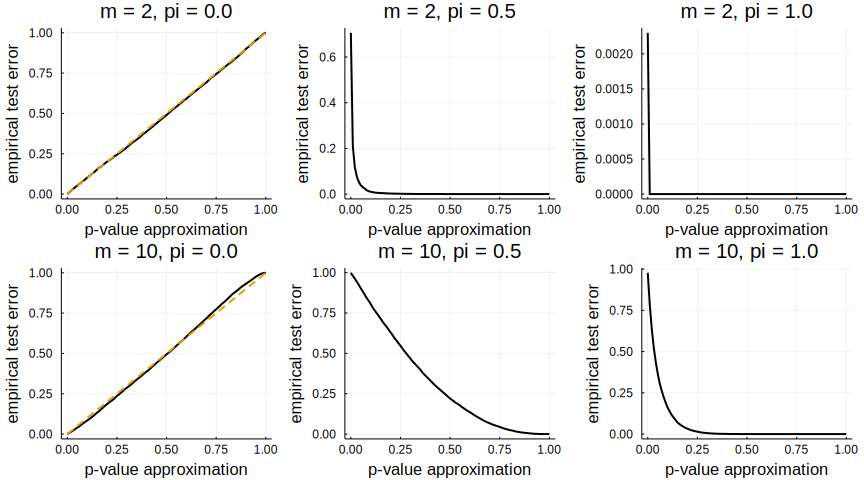

In [64]:
errorgrid("SKCEuq_mean_asymptotic"; αᵢ = 1.0, only_firstclass = false)

#### Non-uniform predictions and uniform labels

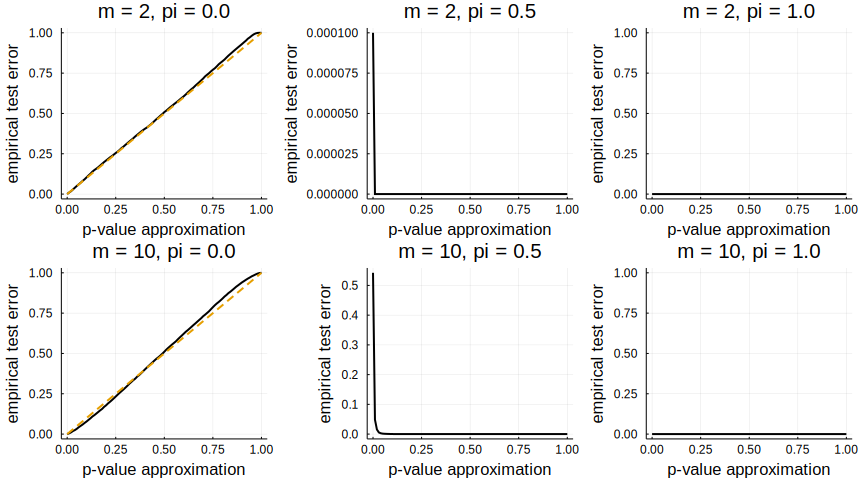

In [65]:
errorgrid("SKCEuq_mean_asymptotic"; αᵢ = 0.1, only_firstclass = false)

#### Uniform predictions and non-uniform labels

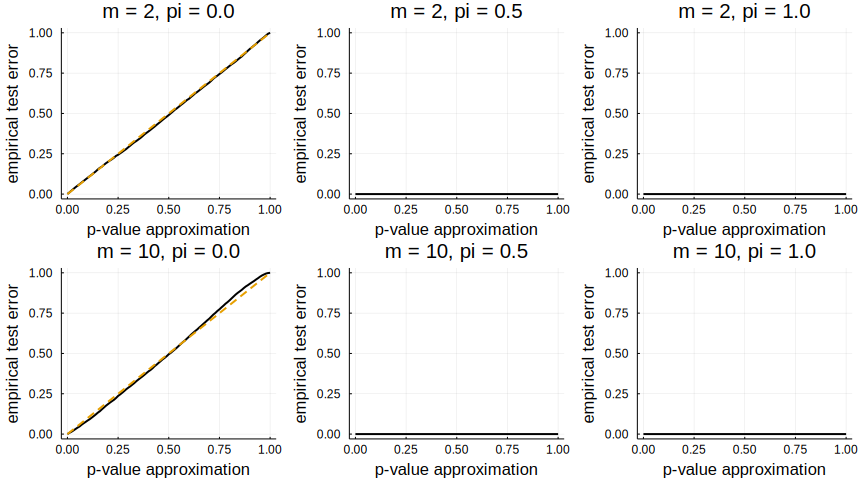

In [66]:
errorgrid("SKCEuq_mean_asymptotic"; αᵢ = 1.0, only_firstclass = true)

#### Non-uniform predictions and non-uniform labels

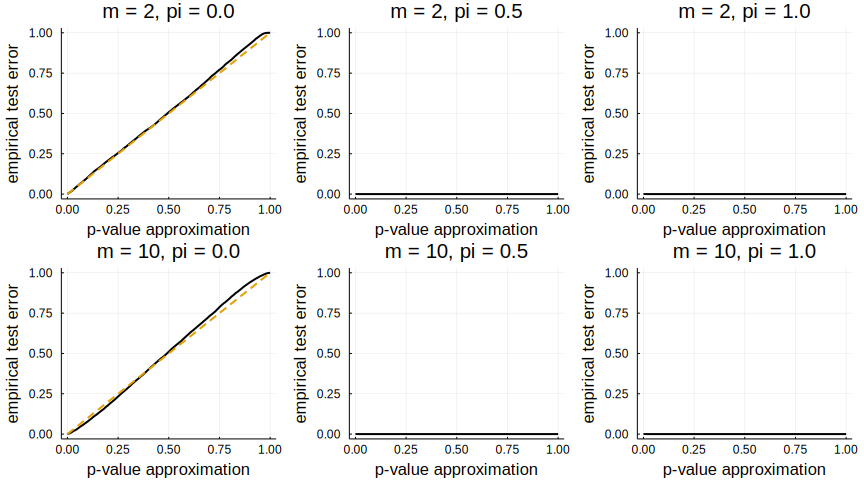

In [67]:
errorgrid("SKCEuq_mean_asymptotic"; αᵢ = 0.1, only_firstclass = true)